In [1]:
import os, sys
from pathlib import Path
import torch

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

ncomps = 60
model_comps = 500
dr_method = 'PCA'

exp_name="far_bias"

test_path = train_path = macaw_path/exp_name/f'test_hc_data_PCA_{model_comps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{model_comps}'/f'{ncomps}'

In [2]:
import pickle

with open(test_path, 'rb') as f:
    test = pickle.load(f)
    
disease = test['disease']
bias = test['bias']
test_imgs = test['imgs']

encoded_data = test['encoded_data']
pca = test['pca']

In [3]:
with open(model_base_path/'hyperparameters.pkl', 'rb') as f:
    hp = pickle.load(f)
    
ncomps= hp['ncomps']
nevecs= hp['nevecs']
nbasecomps= hp['nbasecomps']
ncauses= hp['ncauses']
crop_size= hp['crop_size']

In [4]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def recons(age,bmi,latents, latent_offset=0):
    
    # bmi = scaler_b.inverse_transform(bmi)
    # print(age)
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    # latent_enc = scaler_i.inverse_transform(latent_enc)
    imgs = pca.inverse_transform(latent_enc)
    return age,bmi,imgs

In [5]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

In [10]:
def make_img(x):
    img = (255*x/np.max(x)).reshape(crop_size,crop_size)
    return np.clip(img,0, 255).astype('uint8')

In [11]:
import glob
from PIL import Image

def make_gif(frames, save_name):    
    frames = [Image.fromarray(f) for f in frames]
    frame_one = frames[0]
    return frame_one.save(save_name, format="GIF", append_images=frames, save_all=True, duration=100, loop=0)

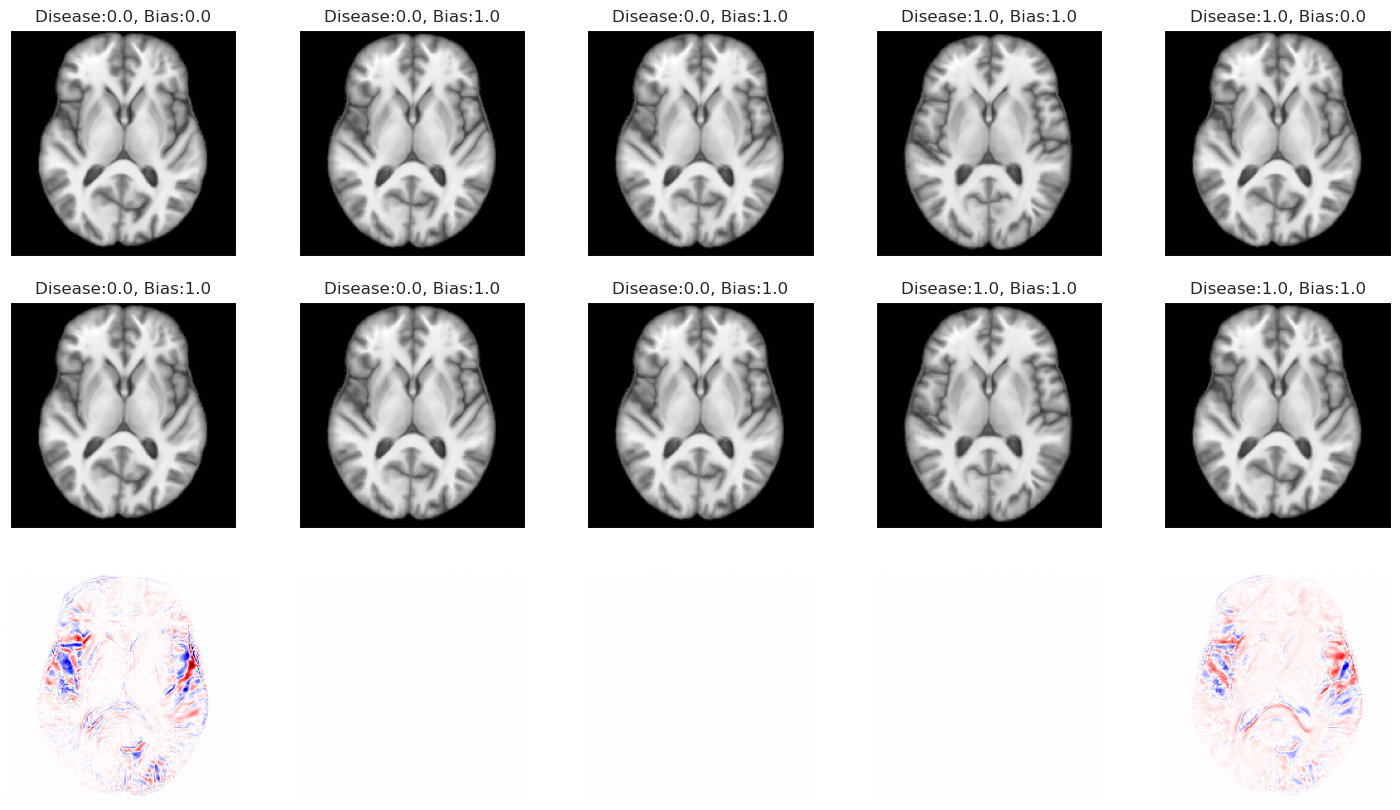

In [18]:
for kk in range(1):
    save_name = f'data/{exp_name}/cntr/'
    cf_vals = {1:1}
    nsamples = 5

    rands = np.random.randint(0,encoded_data.shape[0],nsamples)
    d_obs = test_imgs[rands,:]
    encoded_obs = encoded_data[rands,:]

    dis_obs = disease[rands]
    bias_obs = bias[rands]
    residuals = d_obs - pca.inverse_transform(encoded_obs)

    cf = np.zeros((nsamples,ncomps))  
    
    for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
        ed =  encoded_obs[:,ev:ev+nevecs]
        X_obs = np.hstack([dis_obs[:,np.newaxis], bias_obs[:,np.newaxis], ed])
        try:
            macaw = torch.load(model_base_path/f'{ev}.pt')
            cc = macaw.counterfactual(X_obs,cf_vals)
        except Exception as e:
            print(e,"Using original")
            cc[:,ncauses:] = X_obs[:,ncauses:].copy()

        cf[:,ev:ev+nevecs] = cc[:,ncauses:]

    re_cf = recons(cc[:,1],cc[:,2],cf)
    re_cf_resd = re_cf[2] + residuals

    diff = d_obs - re_cf_resd

    fig,axs = plt.subplots(3,nsamples, figsize=(18,10))

    for i in range(nsamples):
        axs[0,i].imshow(d_obs[i].reshape(crop_size,crop_size),cmap='gray')
        axs[0,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{X_obs[i,0]}, Bias:{X_obs[i,1]}')

        axs[1,i].imshow(make_img(re_cf_resd[i]),cmap='gray')
        axs[1,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f'Disease:{cc[i,0]}, Bias:{cc[i,1]}')

        axs[2,i].imshow(diff[i].reshape(crop_size,crop_size),cmap='seismic', clim=(-5e-2,5e-2))
        axs[2,i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if not os.path.exists(save_name):
        os.makedirs(save_name)

    plt.savefig(save_name+f"{kk}.pdf")
    plt.show()